# (Generalized) Procrustes analysis with Python/NumPy

##### From https://medium.com/@olga_kravchenko/generalized-procrustes-analysis-with-python-numpy-c571e8e8a421

### Packages

In [51]:
%config Completer.use_jedi = False

import cv2
import numpy as np
import pandas as pd
from random import randint
from scipy.linalg import norm
from math import sin, cos, atan, pi
from matplotlib import pyplot as plt

### Generate test shapes

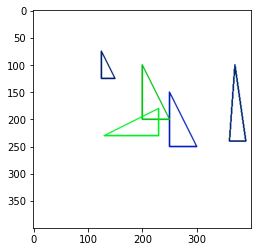

In [52]:
# def show_image(img):
#     '''
#     Displays an image
#     Args:
#         img(a NumPy array of type uint 8) an image to be
#         dsplayed
#     '''
    
#     cv2.imshow('', img)
#     cv2.waitKey(10000) & 0xFF
    
def generate_color(shapes):
    '''
    Generates a random combination
    of red, green and blue channels
    Returns:
        (r,g,b), a generated tuple
    '''
    colors = []
    
    for i in range(len(shapes)): 
    
        col = [0]
        for j in range(2):
            col.append(randint(0, 255))

        colors.append(tuple(col))
        
    return colors

def create_test_set():
    
    #create canvas on which the triangles will be visualized
    canvas = np.full([400,400], 255).astype('uint8')
    
    #convert to 3 channel RGB for fun colors!
    canvas = cv2.cvtColor(canvas,cv2.COLOR_GRAY2RGB)
    
    #initialize triangles as sets of vertex coordinates (x,y)
    triangles = []
    triangles.append(np.array([250,250, 250,150, 300,250]))
    #tr1 translated by 50 points on both axis
    triangles.append(triangles[0] - 50)
    #tr1 shrinked and consequently translated as well
    triangles.append((triangles[0] / 2).astype(np.int))
    #tr1 rotated by 90 defrees annd translated by 20 pixels
    triangles.append(np.array([250,250,150,250, 250, 200]) - 20)
    #a random triangle
    triangles.append(np.array([360,240, 370,100, 390, 240]))
    
    return canvas, triangles

def draw_shapes(canvas, shapes):
    '''
    Draws shapes on canvas
    Args:
        canvas(a NumPy matrix), a background on which
        shapes are drawn
        shapes(list), shapes to be drawn
    '''
    
    for i, sh in enumerate(shapes):
        pts = sh.reshape((-1,1,2))
        color = colors[i]
        cv2.polylines(canvas, [pts], True, color, 2)
    
#     show_image(canvas)

canvas, triangles = create_test_set()
colors = generate_color(triangles)
draw_shapes(canvas, triangles)

plt.imshow(canvas)
plt.show()

### Center all shapes at origin

In [53]:
def get_translation(shape):
  '''
  Calculates a translation for x and y
  axis that centers shape around the
  origin
  Args:
    shape(2n x 1 NumPy array) an array 
    containing x coodrinates of shape
    points as first column and y coords
    as second column
   Returns:
    translation([x,y]) a NumPy array with
    x and y translationcoordinates
  '''
  
  mean_x = np.mean(shape[::2]).astype(np.int)
  mean_y = np.mean(shape[1::2]).astype(np.int)
  
  return np.array([mean_x, mean_y])

def translate(shape):
  '''
  Translates shape to the origin
    arrays inside functions are mutated (i.e. they act like global variables)
    so return is not required
  Args:
    shape(2n x 1 NumPy array) an array 
    containing x coodrinates of shape
    points as first column and y coords
    as second column
  '''
  mean_x, mean_y = get_translation(shape)
  shape[::2] -= mean_x
  shape[1::2] -= mean_y

### Scale and rotate

In [54]:
def get_rotation_scale(reference_shape, shape):
    '''
    Calculates rotation and scale
    that would optimally align shape
    with reference shape
    Args:
        reference_shape(2nx1 NumPy array), a shape that
        serves as reference for scaling and 
        alignment
        
        shape(2nx1 NumPy array), a shape that is scaled
        and aligned
        
    Returns:
        scale(float), a scaling factor
        theta(float), a rotation angle in radians
    '''
    
    a = np.dot(shape, reference_shape) / norm(reference_shape)**2
    
    #separate x and y for the sake of convenience
    ref_x = reference_shape[::2]
    ref_y = reference_shape[1::2]
    
    x = shape[::2]
    y = shape[1::2]
    
    b = np.sum(x*ref_y - ref_x*y) / norm(reference_shape)**2
    
    scale = np.sqrt(a**2+b**2)
    theta = atan(b / max(a, 10**-10)) #avoid dividing by 0
    
    return round(scale,1), round(theta,2)

def get_rotation_matrix(theta):
    
    return np.array([[cos(theta), -sin(theta)], [sin(theta), cos(theta)]])

def scale(shape, scale):
    
    return shape / scale

def rotate(shape, theta):
    '''
    Rotates a shape by angle theta
    Assumes a shape is centered around 
    origin
    Args:
        shape(2nx1 NumPy array) an shape to be rotated
        theta(float) angle in radians
    Returns:
        rotated_shape(2nx1 NumPy array) a rotated shape
    '''
    
    matr = get_rotation_matrix(theta)
    
    #reshape so that dot product is eascily computed
    temp_shape = shape.reshape((-1,2)).T
    
    #rotate
    rotated_shape = np.dot(matr, temp_shape)
    
    return rotated_shape.T.reshape(-1)

### Procrustes analysis

In [55]:
def procrustes_analysis(reference_shape, shape):
    '''
    Scales, and rotates a shape optimally to
    be aligned with a reference shape
    Args:
        reference_shape(2nx1 NumPy array), a shape that
        serves as reference alignment
        
        shape(2nx1 NumPy array), a shape that is aligned
        
    Returns:
        aligned_shape(2nx1 NumPy array), an aligned shape
        translated to the location of reference shape
    '''
    #copy both shapes in caseoriginals are needed later
    temp_ref = np.copy(reference_shape)
    temp_sh = np.copy(shape)
 
    translate(temp_ref)
    translate(temp_sh)
    
    #get scale and rotation
    scale, theta = get_rotation_scale(temp_ref, temp_sh)
    
    #scale, rotate both shapes
    temp_sh = temp_sh / scale
    aligned_shape = rotate(temp_sh, theta)
    
    return aligned_shape

### Procrustes distance

In [56]:
def procrustes_distance(reference_shape, shape):
    
    ref_x = reference_shape[::2]
    ref_y = reference_shape[1::2]
    
    x = shape[::2]
    y = shape[1::2]
    
#     dist = np.sum(np.sqrt((ref_x - x)**2 + (ref_y - y)**2))
# the original appears to be a sum of square roots instead of 
# a square root of sums, which is what the partial procrustes distance is
    dist = np.sqrt(np.sum((ref_x - x)**2 + (ref_y - y)**2))
    
    return dist

### Procrustes on test shapes

[0.0, 122.47448713915891, 301.0398644698074, 177.2004514666935, 193.13207915827965]


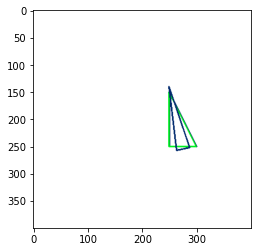

In [57]:
canvas, triangles = create_test_set()
#get translation of reference landmark
x_trans,y_trans = get_translation(triangles[0])
#create array for new shapes, append reference shape to it
new_shapes = []
# new_shapes.append(triangles[0])
procrustes_dists = []

#superimpose all shapes to reference shape
for i in range(5):
    new_shape = procrustes_analysis(triangles[0], triangles[i])
    new_shape[::2] = new_shape[::2] + x_trans
    new_shape[1::2] = new_shape[1::2] + y_trans
    new_shapes.append(new_shape)
    procrustes_dist = procrustes_distance(triangles[0], triangles[i])
    procrustes_dists.append(procrustes_dist)

#convert coordinates in new_shapes to nearest integer values
new_shapes = [np.rint(float_shape).astype(int) for float_shape in new_shapes]
print(procrustes_dists)
# colors = generate_color(new_shapes)
draw_shapes(canvas, new_shapes)
plt.imshow(canvas)
plt.show()

In [58]:
def generalized_procrustes_analysis(shapes):
    '''
    Performs superimposition on a set of 
    shapes, calculates a mean shape
    Args:
        shapes(a list of 2nx1 Numpy arrays), shapes to
        be aligned
    Returns:
        mean(2nx1 NumPy array), a new mean shape
        aligned_shapes(a list of 2nx1 Numpy arrays), super-
        imposed shapes
    '''
    #initialize Procrustes distance
    current_distance = 0
    
    #initialize a mean shape
    mean_shape = np.array(shapes[0])

    num_shapes = len(shapes)
    
    #create array for new shapes, add 
    new_shapes = np.zeros(np.array(shapes).shape)
    
    
    while True:
        
        #add the mean shape as first element of array
        new_shapes[0] = mean_shape
        
        #superimpose all shapes to current mean
        for sh in range(num_shapes):
            new_sh = procrustes_analysis(mean_shape, shapes[sh])
            new_shapes[sh] = new_sh
        
        #calculate new mean
        new_mean = np.mean(new_shapes, axis = 0)
        
        new_distance = procrustes_distance(new_mean, mean_shape)

        #if the distance did not change, break the cycle
        if new_distance == current_distance:
            break
        
        #align the new_mean to old mean
        new_mean = procrustes_analysis(mean_shape, new_mean)
        
        #update mean and distance
        mean_shape = new_mean
        current_distance = new_distance
        
        mean_shape = np.rint(mean_shape).astype(int)
        new_shapes = np.rint(new_shapes).astype(int)
        
    #create array for Procrustes distances
    new_dists = np.zeros(num_shapes)

    for i in range(num_shapes):
        new_dists[i] = procrustes_distance(mean_shape, new_shapes[i])
        
    new_dists = new_dists.reshape(-1, 1) # converts 1-D row into column
        
    return mean_shape, new_shapes, new_dists

In [59]:
gpa_mean, gpa_new, gpa_dists = generalized_procrustes_analysis(triangles)

In [60]:
gpa_dists

array([[ 3.87298335],
       [ 3.87298335],
       [ 3.87298335],
       [ 4.        ],
       [16.70329309]])

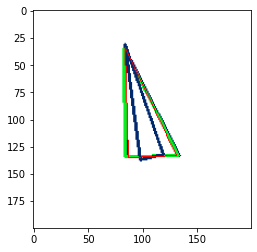

In [61]:
# colors = generate_color(gpa_new + 100)
canvas = np.full([200,200], 255).astype('uint8')
canvas = cv2.cvtColor(canvas,cv2.COLOR_GRAY2RGB)
draw_shapes(canvas, gpa_new + 100)

pts = gpa_mean.reshape((-1,1,2)) + 100
color = (255, 0, 0)
cv2.polylines(canvas, [pts], True, color, 1)

plt.imshow(canvas)
plt.show()

In [62]:
shape0 = np.genfromtxt('shape1.csv', delimiter=",")[1:,5:]
shape1 = np.genfromtxt('shape2.csv', delimiter=",")[1:,5:]
shape2 = np.genfromtxt('shape3.csv', delimiter=",")[1:,5:]
shape3 = np.genfromtxt('shape4.csv', delimiter=",")[1:,5:]

shape0 = np.rint(shape0).astype(int)
shape1 = np.rint(shape1).astype(int)
shape2 = np.rint(shape2).astype(int)
shape3 = np.rint(shape3).astype(int)

In [63]:
shapes = []
shapes.append(shape0.flatten())
shapes.append(shape1.flatten())
shapes.append(shape2.flatten())
shapes.append(shape3.flatten())

In [64]:
colors = generate_color(shapes)
canvas = np.full([400,400], 255).astype('uint8')
canvas = cv2.cvtColor(canvas,cv2.COLOR_GRAY2RGB)
draw_shapes(canvas, shapes)

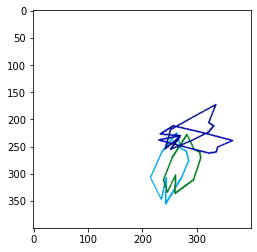

In [65]:
plt.imshow(canvas)
plt.show()

In [66]:
arches_mean, arches_new, arches_dists = generalized_procrustes_analysis(shapes)

In [67]:
arches_dists

array([[16.43167673],
       [17.11724277],
       [14.76482306],
       [10.14889157]])

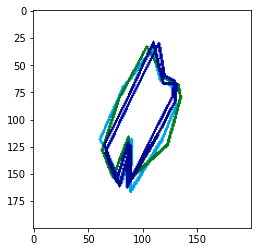

In [68]:
canvas = np.full([200,200], 255).astype('uint8')
canvas = cv2.cvtColor(canvas,cv2.COLOR_GRAY2RGB)
draw_shapes(canvas, arches_new + 100)
plt.imshow(canvas)
plt.show()

In [69]:
min_adjusted = lambda x: (x - np.amin(x) + 10) if np.amin(x) <= 0 else (x + (10 - np.amin(x)) if 0 < np.amin(x) < 10 else (x - (np.amin(x) - 10))) # adjusts minima so that there is a buffer of 10 px

In [70]:
arches_new_adjusted = arches_new.copy()
arches_new_adjusted[:, ::2] = min_adjusted(arches_new[:, ::2])
arches_new_adjusted[:, 1::2] = min_adjusted(arches_new[:, 1::2])

arches_mean_adjusted = arches_mean.copy()
arches_mean_adjusted[::2] = arches_mean_adjusted[::2] + arches_new_adjusted[0, 0] - arches_new[0,0]
arches_mean_adjusted[1::2] = arches_mean_adjusted[1::2] + arches_new_adjusted[0, 1] - arches_new[0,1]

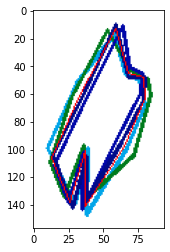

In [71]:
canvas = np.full([np.amax(arches_new_adjusted[:, 1::2]) + 10, np.amax(arches_new_adjusted[:, ::2]) + 10], 255).astype('uint8')
canvas = cv2.cvtColor(canvas,cv2.COLOR_GRAY2RGB)
draw_shapes(canvas, arches_new_adjusted)

pts = arches_mean_adjusted.reshape((-1,1,2))
color = (255, 0, 0)
cv2.polylines(canvas, [pts], True, color, 1)

plt.imshow(canvas)
plt.show()

In [72]:
shapes_adjusted = np.array(shapes)
shapes_adjusted[:, ::2] = min_adjusted(np.array(shapes)[:, ::2])
shapes_adjusted[:, 1::2] = min_adjusted(np.array(shapes)[:, 1::2])

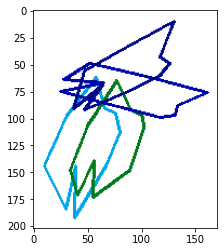

In [73]:
canvas = np.full([np.amax(shapes_adjusted[:, 1::2]) + 10, np.amax(shapes_adjusted[:, ::2]) + 10], 255).astype('uint8')
canvas = cv2.cvtColor(canvas,cv2.COLOR_GRAY2RGB)
draw_shapes(canvas, shapes_adjusted)
plt.imshow(canvas)
plt.show()

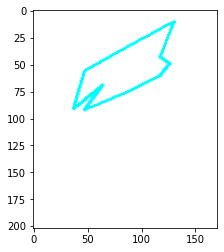

In [74]:
canvas = np.full([np.amax(shapes_adjusted[:, 1::2]) + 10, np.amax(shapes_adjusted[:, ::2]) + 10], 255).astype('uint8')
canvas = cv2.cvtColor(canvas,cv2.COLOR_GRAY2RGB)

pts = shapes_adjusted[3].reshape((-1,1,2))
color = (0, 255, 255)
cv2.polylines(canvas, [pts], True, color, 2)

plt.imshow(canvas)
plt.show()

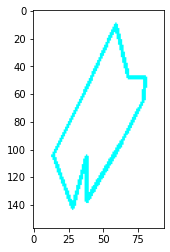

In [75]:
canvas = np.full([np.amax(arches_new_adjusted[:, 1::2]) + 10, np.amax(arches_new_adjusted[:, ::2]) + 10], 255).astype('uint8')
canvas = cv2.cvtColor(canvas,cv2.COLOR_GRAY2RGB)

pts = arches_new_adjusted[3].reshape((-1,1,2))
color = (0, 255, 255)
cv2.polylines(canvas, [pts], True, color, 2)

plt.imshow(canvas)
plt.show()

In [76]:
def init_angle(x1, y1, x2, y2):
    try:
        slope = (float(y2)-float(y1))/((float(x2)-float(x1)))
    except:
        slope = 0
        
    return atan(slope)

In [77]:
initial_angle = init_angle(0, 0, 2, 2)
initial_angle

0.7853981633974483

In [78]:
shapes_adjusted[0]

array([ 38, 192,  39, 144,  30, 184,  10, 144,  31,  97,  58,  62,  66,
        91,  76,  95,  80, 113,  67, 144])

In [79]:
shapes_adjusted[0]

array([ 38, 192,  39, 144,  30, 184,  10, 144,  31,  97,  58,  62,  66,
        91,  76,  95,  80, 113,  67, 144])

In [80]:
type(shapes)

list

In [81]:
type(triangles)

list

In [82]:
triangles

[array([250, 250, 250, 150, 300, 250]),
 array([200, 200, 200, 100, 250, 200]),
 array([125, 125, 125,  75, 150, 125]),
 array([230, 230, 130, 230, 230, 180]),
 array([360, 240, 370, 100, 390, 240])]

In [83]:
shapes

[array([243, 355, 244, 307, 235, 347, 215, 307, 236, 260, 263, 225, 271,
        254, 281, 258, 285, 276, 272, 307]),
 array([260, 336, 261, 302, 246, 334, 239, 311, 255, 270, 282, 228, 295,
        255, 306, 261, 307, 272, 294, 311]),
 array([230, 238, 270, 230, 233, 227, 257, 212, 305, 223, 366, 239, 338,
        251, 336, 260, 322, 262, 283, 252]),
 array([252, 255, 269, 232, 242, 254, 252, 219, 291, 197, 335, 173, 322,
        206, 331, 212, 322, 223, 293, 238])]

In [84]:
shapes[0]

array([243, 355, 244, 307, 235, 347, 215, 307, 236, 260, 263, 225, 271,
       254, 281, 258, 285, 276, 272, 307])

In [85]:
shapes2 = shapes.copy()

In [86]:
shapes[0]

array([243, 355, 244, 307, 235, 347, 215, 307, 236, 260, 263, 225, 271,
       254, 281, 258, 285, 276, 272, 307])

In [87]:
shapes2[0]

array([243, 355, 244, 307, 235, 347, 215, 307, 236, 260, 263, 225, 271,
       254, 281, 258, 285, 276, 272, 307])

In [88]:
# for shp in shapes2:

#     initial_angle = init_angle(shp[0], shp[1], shp[16], shp[17])
#     shp = translate(shp)
#     print(type(shape))
#     print(shape)

#     shape = rotate(shape, initial_angle)

In [89]:
for i in range(len(shapes2)):
    initial_angle = init_angle(shapes2[i][0], shapes2[i][1], shapes2[i][16], shapes2[i][17])
#     print(i)
#     print("shapes2[i]\n", shapes2[i], type(shapes2[i]))
#     print("shapes[i]\n", shapes[i], type(shapes[i]))
    shapes2[i] = shapes[i].copy()
#     print("shapes2[i]\n", shapes2[i], type(shapes2[i]))
    
    translate(shapes2[i])
#     print("shapes[i]\n", shapes[i], type(shapes[i]))
    print("shapes2[i]\n", shapes2[i], type(shapes2[i]))
    
    shapes2[i] = rotate(shapes2[i], -initial_angle)
    print("shapes2[i]\n", shapes2[i], type(shapes2[i]), "\n")

shapes2[i]
 [-11  66 -10  18 -19  58 -39  18 -18 -29   9 -64  17 -35  27 -31  31 -13
  18  18] <class 'numpy.ndarray'>
shapes2[i]
 [-63.43978736  21.26954111 -20.5877534   -0.38001282 -60.13144045
  10.45035257 -34.20115386 -25.98617083  17.15646117 -29.50687784
  60.73499023 -22.09662784  38.88425304  -1.41945965  40.0466452
   9.28796041  26.03087822  21.26954111  -7.44378055  24.34317422] <class 'numpy.ndarray'> 

shapes2[i]
 [-14  48 -13  14 -28  46 -35  23 -19 -18   8 -60  21 -33  32 -27  33 -16
  20  23] <class 'numpy.ndarray'>
shapes2[i]
 [-46.97494566  17.12759413 -18.97888555  -2.19132454 -53.64966984
   4.65971311 -39.25493448 -14.59623647   3.26179918 -25.96845521
  53.09554179 -29.06653474  39.02824573  -2.60692058  40.70322369
   9.81058517  32.42908447  17.12759413  -6.69991182  29.73400716] <class 'numpy.ndarray'> 

shapes2[i]
 [-64  -1 -24  -9 -61 -12 -37 -27  11 -16  72   0  44  12  42  21  28  23
 -11  13] <class 'numpy.ndarray'>
shapes2[i]
 [-62.17992733  15.18738415

In [90]:
shapes

[array([243, 355, 244, 307, 235, 347, 215, 307, 236, 260, 263, 225, 271,
        254, 281, 258, 285, 276, 272, 307]),
 array([260, 336, 261, 302, 246, 334, 239, 311, 255, 270, 282, 228, 295,
        255, 306, 261, 307, 272, 294, 311]),
 array([230, 238, 270, 230, 233, 227, 257, 212, 305, 223, 366, 239, 338,
        251, 336, 260, 322, 262, 283, 252]),
 array([252, 255, 269, 232, 242, 254, 252, 219, 291, 197, 335, 173, 322,
        206, 331, 212, 322, 223, 293, 238])]

In [91]:
shapes2

[array([-63.43978736,  21.26954111, -20.5877534 ,  -0.38001282,
        -60.13144045,  10.45035257, -34.20115386, -25.98617083,
         17.15646117, -29.50687784,  60.73499023, -22.09662784,
         38.88425304,  -1.41945965,  40.0466452 ,   9.28796041,
         26.03087822,  21.26954111,  -7.44378055,  24.34317422]),
 array([-46.97494566,  17.12759413, -18.97888555,  -2.19132454,
        -53.64966984,   4.65971311, -39.25493448, -14.59623647,
          3.26179918, -25.96845521,  53.09554179, -29.06653474,
         39.02824573,  -2.60692058,  40.70322369,   9.81058517,
         32.42908447,  17.12759413,  -6.69991182,  29.73400716]),
 array([-62.17992733,  15.18738415, -25.49461161,  -2.65042992,
        -62.05371638,   3.78632846, -42.6172303 , -16.78605616,
          6.60503964, -18.25851723,  69.66844361, -18.17437659,
         45.60422275,   0.50484379,  45.94078528,   9.71824304,
         32.89898726,  15.18738415,  -7.36230533,  15.35566541]),
 array([-49.11162168,  16.03273576

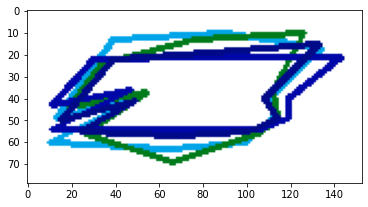

In [92]:
shapes2_adjusted = np.rint(np.array(shapes2)).astype(int)
shapes2_adjusted[:, ::2] = min_adjusted(np.array(shapes2)[:, ::2])
shapes2_adjusted[:, 1::2] = min_adjusted(np.array(shapes2)[:, 1::2])

canvas = np.full([np.amax(shapes2_adjusted[:, 1::2]) + 10, np.amax(shapes2_adjusted[:, ::2]) + 10], 255).astype('uint8')
canvas = cv2.cvtColor(canvas,cv2.COLOR_GRAY2RGB)
draw_shapes(canvas, shapes2_adjusted)
plt.imshow(canvas)
plt.show()

In [93]:
arches2_mean, arches2_new, arches2_dists = generalized_procrustes_analysis(shapes2)

In [94]:
arches2_new_adjusted = arches2_new.copy()
arches2_new_adjusted[:, ::2] = min_adjusted(arches2_new[:, ::2])
arches2_new_adjusted[:, 1::2] = min_adjusted(arches2_new[:, 1::2])

arches2_mean_adjusted = arches2_mean.copy()
arches2_mean_adjusted[::2] = arches2_mean_adjusted[::2] + arches2_new_adjusted[0, 0] - arches2_new[0,0]
arches2_mean_adjusted[1::2] = arches2_mean_adjusted[1::2] + arches2_new_adjusted[0, 1] - arches2_new[0,1]

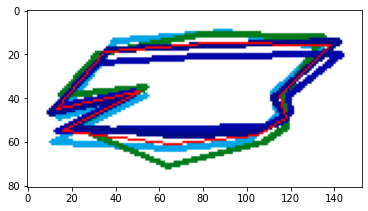

In [95]:
canvas = np.full([np.amax(arches2_new_adjusted[:, 1::2]) + 10, np.amax(arches2_new_adjusted[:, ::2]) + 10], 255).astype('uint8')
canvas = cv2.cvtColor(canvas,cv2.COLOR_GRAY2RGB)
draw_shapes(canvas, arches2_new_adjusted)

pts = arches2_mean_adjusted.reshape((-1,1,2))
color = (255, 0, 0)
cv2.polylines(canvas, [pts], True, color, 1)

plt.imshow(canvas)
plt.show()

In [96]:
arches2_dists

array([[16.94107435],
       [17.32050808],
       [15.32970972],
       [10.09950494]])

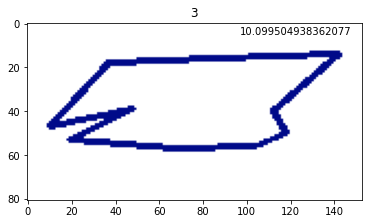

In [97]:
n = 3

canvas = np.full([np.amax(arches2_new_adjusted[:, 1::2]) + 10, np.amax(arches2_new_adjusted[:, ::2]) + 10], 255).astype('uint8')
canvas = cv2.cvtColor(canvas,cv2.COLOR_GRAY2RGB)

pts = arches2_new_adjusted[n].reshape((-1,1,2))
color = colors[n]
cv2.polylines(canvas, [pts], True, color, 2)

plt.text(np.amax(arches2_new_adjusted[:, ::2]) + 5, 5, arches2_dists[n][0], horizontalalignment='right')
plt.title(n)
plt.imshow(canvas)
plt.show()

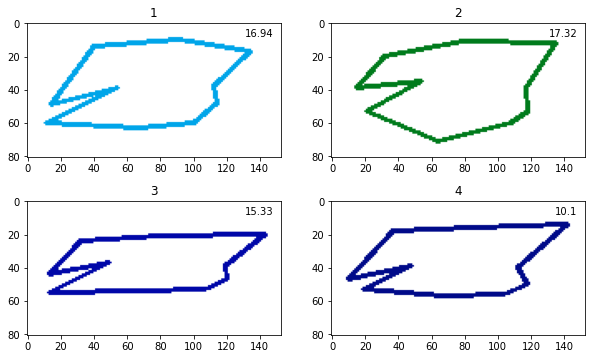

In [98]:
plt.figure(figsize = (10, 6))

for n in range(len(arches2_dists)):
    
    canvas = np.full([np.amax(arches2_new_adjusted[:, 1::2]) + 10, np.amax(arches2_new_adjusted[:, ::2]) + 10], 255).astype('uint8')
    canvas = cv2.cvtColor(canvas,cv2.COLOR_GRAY2RGB)
    pts = arches2_new_adjusted[n].reshape((-1,1,2))
    color = colors[n]
    cv2.polylines(canvas, [pts], True, color, 2)

    
    plt.subplot(2, 2, n+1)
    plt.text(np.amax(arches2_new_adjusted[:, ::2]) + 5, 8, round(arches2_dists[n][0], 2), horizontalalignment='right')
    plt.title(n+1)
    plt.imshow(canvas)

    
plt.show()

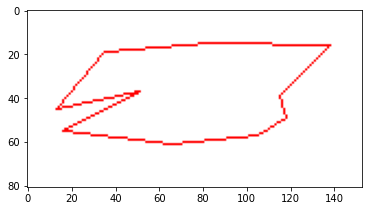

In [99]:
canvas = np.full([np.amax(arches2_new_adjusted[:, 1::2]) + 10, np.amax(arches2_new_adjusted[:, ::2]) + 10], 255).astype('uint8')
canvas = cv2.cvtColor(canvas,cv2.COLOR_GRAY2RGB)


pts = arches2_mean_adjusted.reshape((-1,1,2))
color = (255, 0, 0)
cv2.polylines(canvas, [pts], True, color, 1)

plt.imshow(canvas)
plt.show()

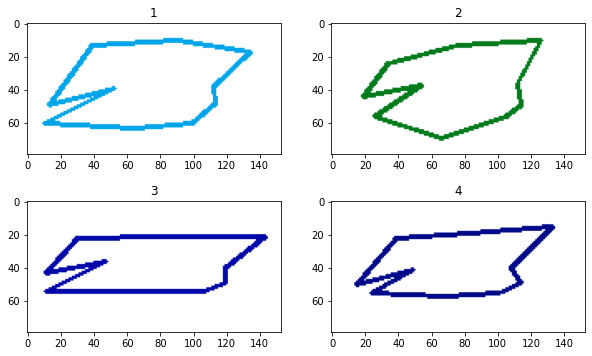

In [100]:
plt.figure(figsize = (10, 6))

for n in range(len(arches2_dists)):
    
    canvas = np.full([np.amax(shapes2_adjusted[:, 1::2]) + 10, np.amax(shapes2_adjusted[:, ::2]) + 10], 255).astype('uint8')
    canvas = cv2.cvtColor(canvas,cv2.COLOR_GRAY2RGB)
    pts = shapes2_adjusted[n].reshape((-1,1,2))
    color = colors[n]
    cv2.polylines(canvas, [pts], True, color, 2)

    
    plt.subplot(2, 2, n+1)
    plt.title(n+1)
    plt.imshow(canvas)

    
plt.show()

AttributeError: module 'matplotlib.pyplot' has no attribute 'fi'